# Netoyage des données

In [1]:
import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', 184)
pd.set_option('display.max_rows', 184)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_seq_items', 184)
pd.set_option('display.width', 50)

In [3]:
class Chrono(object):  
    def __init__(self):
        self.start()
    def start(self):  
        if hasattr(self, 'interval'):  
            del self.interval  
        self.start_time = time.time()  
  
    def stop(self):  
        if hasattr(self, 'start_time'):  
            self.interval = time.time() - self.start_time  
            del self.start_time # Force timer reinit  
            print('{h}:%.3f temps passé'.format(h = int(self.interval//60)) % (self.interval%60))

In [5]:
df = pd.read_csv("D:/Jayma/Machine Learning/data set/Projet 1/en.openfoodfacts.org.products.csv", sep= "\t")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,12,18,19,20,21,22,26,27,28,30,51,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df = df.drop_duplicates(subset='code')

In [7]:
df = df.set_index('code')

In [8]:
sampled_df = df.sample(frac = 0.01)

In [9]:
sampled_df.to_csv('D:/Jayma/Machine Learning/data set/Projet 1/test_en.csv')

In [4]:
sampled_df = pd.read_csv("D:/Jayma/Machine Learning/data set/Projet 1/test_en.csv")

Pour avoir un visuel de la base de donnée.

In [ ]:
plt.figure(figsize=(50,20))
sns.heatmap(sampled_df.isna(), cbar=False)

# Fonctions

In [5]:
def netoyageCat(serie, seuil=20, new_val="Autre", fillna=True):
    mask_bool = serie.value_counts() < seuil
    mask_autre = mask_bool.copy()
    mask_autre[mask_bool] = new_val
    serie = serie.replace(mask_autre[mask_bool])
    if fillna:
        serie.fillna(new_val, inplace=True)
    return serie

In [6]:
def multiOnehotTags(serie):
    load=0
    df_temp = pd.DataFrame()
    for i in range(serie.shape[0]):
        val = serie.loc[i]
        if type(val) == str:
            for r in range(val.count('en:')):
                virgule = val.find(',')
                if virgule == -1:
                    df_temp.loc[i,val[3:]] = 1
                else:
                    df_temp.loc[i,val[3:virgule]] = 1
                    val = val[virgule+1:]
        else:
            df_temp.loc[i,:] = 0
        if load < i//1000:
            load = i//1000
            clear_output(wait=True)
            print(i, '/', serie.shape[0], '(%.4f)' % (i/serie.shape[0]))
    df_temp.fillna(0, inplace=True)
    return df_temp

In [8]:
def dropOnehot(df, seuil):
    r=0
    liste_drop = []
    for i in range(df.shape[1]):
        if df.iloc[:,i].value_counts()[1.0] < seuil:
            liste_drop.append(df.columns[i])
            r+=1
    print(r,' colonnes ejecte dans ', df.shape[1] ,' colonnes')
    return df.drop(liste_drop, axis=1)

In [7]:
def Onehot(serie):
    load=0
    df_temp = pd.DataFrame()
    for i in range(serie.shape[0]):
        val = serie.loc[i]
        if type(val) == str:
            df_temp.loc[i,val] = 1
        else:
            df_temp.loc[i,:] = 0
        if load < i//1000:
            load = i//1000
            clear_output(wait=True)
            print(i, '/', serie.shape[0], '(%.4f)' % (i/serie.shape[0]))
    df_temp.fillna(0, inplace=True)
    return df_temp

In [9]:
def listMainCat(serie, seuil=1, en=''):
    serie_temp = pd.Series()
    serie_values = serie.value_counts()
    for i in range(serie_values.shape[0]):
        val = serie_values.index[i]
        for r in range(val.count(',')+1):
            virgule = val.find(',')
            if virgule == -1:
                if val[len(en):] in serie_temp:
                    serie_temp[val[len(en):]] += serie_values[i]
                else:
                    serie_temp[val[len(en):]] = serie_values[i]
            else:
                if val[len(en):virgule] in serie_temp:
                    serie_temp[val[len(en):virgule]] += serie_values[i]
                else:
                    serie_temp[val[len(en):virgule]] = serie_values[i]
                val = val[virgule+1:]
    serie_temp.sort_values(ascending=False)
    for i in range(serie_temp.shape[0]):
        if serie_temp.iloc[i] < seuil:
            serie_temp = serie_temp.iloc[0:i]
            break
    return serie_temp

### analyse bivariée

In [10]:
def coninTab(serieliste1, liste1, serieliste2, liste2, normalize=False):
    reste = pd.Series()
    df_cont = pd.DataFrame()
    for i in range(liste1.shape[0]): # colonne
        for r in range(liste2.shape[0]): # lignes
            df_cont.loc[liste2.index[r], liste1.index[i]] = serieliste2[serieliste2.str.contains(liste2.index[r],na=False, regex=False) & serieliste1.str.contains(liste1.index[i],na=False, regex=False)].shape[0]
        clear_output(wait=True)
        print(i+1, '/', liste1.shape[0])
        df_cont.loc['Le Reste',liste1.index[i]] = liste1[i] - df_cont[liste1.index[i]].sum()
        if normalize:
            df_cont = df_cont/df_cont[liste1.index[i]].sum()
        df_cont.loc['Total',liste1.index[i]] = df_cont[liste1.index[i]].sum()
        reste = serieliste1.str.contains(liste1.index[i],na=False, regex=False) | reste
    for r in range(liste2.shape[0]):
        df_cont.loc[liste2.index[r],'Le Reste'] = serieliste2[serieliste2.str.contains(liste2.index[r],na=False, regex=False) & ~reste].shape[0]
    if normalize:
        df_cont['Le Reste'] = df_cont['Le Reste']/df_cont['Le Reste'].sum()
    df_cont['Total'] = df_cont.sum(axis=1)
    if df_cont.loc['Le Reste'].sum() == 0:
        df_cont.drop(['Le Reste'], axis=0, inplace=True)
    if df_cont.loc[:,'Le Reste'].sum() == 0:
        df_cont.drop(['Le Reste'], axis=1, inplace=True)
    return df_cont

### affichage bivariée

In [11]:
def correspTav(serielisteC, liste1, serielisteR, liste2, annot=False):
    cont = coninTab(serielisteC, liste1, serielisteR, liste2)
    indep = cont.loc[:,["Total"]].dot(cont.loc[["Total"],:])/len(serielisteC)
    measure = (cont-indep)**2/indep
    xi_n = measure.sum().sum()
    print(xi_n)
    table = measure/xi_n
    plt.figure(figsize=(.6*len(liste1),.6*len(liste2)))
    if annot:
        sns.heatmap(table.iloc[:-1,:-1], annot=cont.iloc[:-1,:-1], linewidths=.2)
    else:
        sns.heatmap(table.iloc[:-1,:-1], linewidths=.2)
    plt.show()
    return table, cont

In [12]:
def listBarPlot(serie, serieliste, liste, n_plot=10, moy=False, Autre=False):
    if liste.shape[0] < n_plot:
        n_plot = liste.shape[0]
    reste = pd.Series()
    plt.figure(figsize=(30,7*((n_plot//4)+1)))
    for i in range(n_plot):
        plt.subplot((n_plot//4)+1, 4,i+1)
        val_counts = serie[serieliste.str.contains(liste.index[i],na=False, regex=False)].value_counts()
        if moy:
            val_counts.plot.bar(title='{titre} (moyenne: {moy})'.format(titre = liste.index[i], moy = (val_counts.index * val_counts / val_counts.sum()).sum()))
        else:
            val_counts.plot.bar(title=liste.index[i])
        reste = serieliste.str.contains(liste.index[i],na=False, regex=False) | reste
        plt.legend()
    if Autre:
        plt.subplot((n_plot//4)+1, 4,i+2)
        if moy:
            serie[~reste].value_counts().plot.bar(title='Le Reste (moyenne: {moy})'.format(moy = (serie[~reste].value_counts().index * serie[~reste].value_counts() / serie[~reste].value_counts().sum()).sum()))
        else:
            serie[~reste].value_counts().plot.bar(title='Le Reste')
        plt.legend()
    plt.show()

In [13]:
def biListBarPlot(serieliste1, liste1, serieliste2, liste2, n_plot=10, n_cat=10,Autre=False):
    if liste2.shape[0] < n_plot:
        n_plot = liste2.shape[0]
    reste = pd.Series()
    plt.figure(figsize=(40,7*((n_plot//4)+1)))
    for i in range(n_plot):
        plt.subplot((n_plot//4)+1, 4, i+1)
        serie_sum = pd.Series()
        for r in range(n_cat):
            serie_sum[liste1.index[r]] = serieliste1[serieliste1.str.contains(liste1.index[r],na=False, regex=False) & serieliste2.str.contains(liste2.index[i],na=False, regex=False)].shape[0]
        serie_sum['Le Reste'] = liste2[i] - serie_sum.sum()
        serie_sum.plot.bar(title=liste2.index[i])
        reste = serieliste2.str.contains(liste2.index[i],na=False, regex=False) | reste
        plt.legend()
    if Autre:
        plt.subplot((n_plot//4)+1, 4,i+2)
        serie_sum = pd.Series()
        for r in range(n_cat):
            serie_sum[liste1.index[r]] = serieliste1[serieliste1.str.contains(liste1.index[r],na=False, regex=False) & reste].shape[0]
        serie_sum.plot.bar(title='Le Reste')
        plt.legend()
    plt.show()

### dataframe de base

In [14]:
df_meta = sampled_df[['product_name', 'last_modified_t', 'additives_n', 'nutriscore_score',
                      'nutriscore_grade', 'nova_group', 'energy_100g']]

In [15]:
df_meta_cat = sampled_df[['pnns_groups_1', 'pnns_groups_2', 'brands_tags', 'manufacturing_places_tags', 'labels_tags', 'countries_tags', 'allergens', 'additives_tags', 'origins_tags']]

In [16]:
df_meta_cat['pnns_groups_1'].fillna('unknown',inplace=True)
df_meta_cat['pnns_groups_2'].fillna('unknown',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [17]:
df_meta_cat['pnns_groups_1'].replace(['fruits-and-vegetables', 'sugary-snacks', 'cereals-and-potatoes'], 
                                        ['Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes'], inplace=True)
df_meta_cat['pnns_groups_2'].replace(['Pizza pies and quiches', 'legumes', 'cereals', 'fruits', 'vegetables'], 
                                        ['Pizza pies and quiche', 'Legumes', 'Cereals', 'Fruits', 'Vegetables'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [18]:
df_nutriments = sampled_df.drop(['url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_text', 'brands', 'categories', 'categories_tags', 'categories_en',
                             'origins', 'origins_en', 'manufacturing_places', 'labels', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries',
                             'countries_en', 'ingredients_text', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 
                             'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'states', 'states_tags', 'states_en', 'brand_owner', 'main_category', 
                             'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'product_name', 'brands_tags', 'labels_tags', 'countries_tags', 'allergens',
                             'additives_n', 'additives_tags', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],axis=1)
df_nutriments = df_nutriments.fillna(0)

In [19]:
def trieCat(df, colone):
    load=0
    df_temp = pd.DataFrame()
    for i in range(df.shape[0]):
        val = df.loc[i,colone]
        if type(val) == str:
            for r in range(val.count('en:')):
                virgule = val.find(',')
                if virgule == -1:
                    df_temp.loc[i,val[3:]] = 1
                else:
                    df_temp.loc[i,val[3:virgule]] = 1
                    val = val[virgule+1:]

        if load < i//1000:
            load = i//1000
            clear_output(wait=True)
            print(i, '/', df.shape[0], '(%.4f)' % (i/df.shape[0]))
    df_temp = df_temp.fillna(0)
    return df_temp

## Listes

In [25]:
list_pnns1 = listMainCat(df_meta_cat['pnns_groups_1'])
list_pnns2 = listMainCat(df_meta_cat['pnns_groups_2'])
list_brands = listMainCat(df_meta_cat['brands_tags'], seuil=10)
list_manufactur = listMainCat(df_meta_cat['manufacturing_places_tags'], seuil=10)

<ipython-input-9-8504458445fd>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  serie_temp = pd.Series()


In [26]:
list_labels = listMainCat(df_meta_cat['labels_tags'], seuil=10, en='en:')
list_pays_vente = listMainCat(df_meta_cat['countries_tags'], seuil=10, en='en:')
list_allergens = listMainCat(df_meta_cat['allergens'], seuil=10, en='en:')
list_additives = listMainCat(df_meta_cat['additives_tags'], seuil=10, en='en:')
list_origins = listMainCat(df_meta_cat['origins_tags'], seuil=10, en='en:')

<ipython-input-9-8504458445fd>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  serie_temp = pd.Series()


In [22]:
print('pnns_groups_1', list_pnns1.shape)
print('pnns_groups_2', list_pnns2.shape)
print('brands_tags', list_brands.shape)
print('manufacturing_places_tags', list_manufactur.shape)
print('labels_tags', list_labels.shape)
print('countries_tags', list_pays_vente.shape)
print('allergens', list_allergens.shape)
print('additives_tags', list_additives.shape)
print('origins_tags', list_origins.shape)

pnns_groups_1 (10,)
pnns_groups_2 (40,)
brands_tags (2,)
manufacturing_places_tags (1,)
labels_tags (12,)
countries_tags (9,)
allergens (5,)
additives_tags (15,)
origins_tags (1,)


10 / 10
3468.013145157239


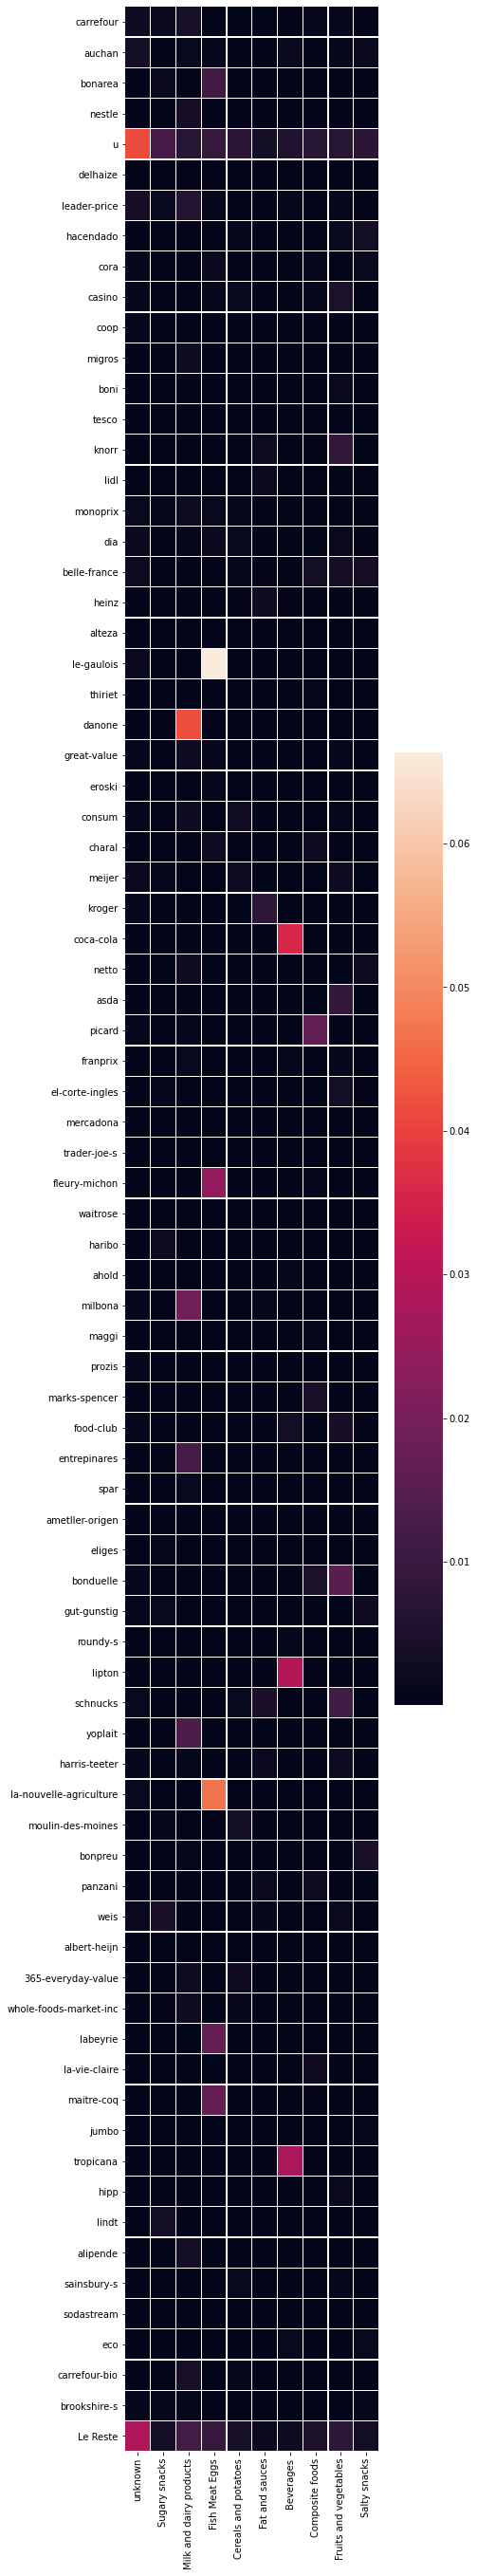

Wall time: 9.22 s


In [29]:
%%time
truc, troc = correspTav(df_meta_cat['pnns_groups_1'], list_pnns1, df_meta_cat['brands_tags'], list_brands, annot=False)

In [122]:
r=0
liste_drop = []
for i in range(df_prov.shape[1]):
  if df_prov.iloc[:,i].value_counts()[1.0] < 100:
    liste_drop.append(df_prov.columns[i])
    r+=1
print(r,' pays ejecte dans ', df_prov.shape[1] ,' pays')

10  pays ejecte dans  19  pays


In [123]:
df_prov.drop(liste_drop ,axis=1, inplace=True)

In [ ]:
test_brands = df_meta['brands_tags'].mask(df_meta['brands_tags'].value_counts() < 50, 1)
test_brands.value_counts()

1    155512
Name: brands_tags, dtype: int64

In [ ]:
print(sampled_df['manufacturing_places_tags'].value_counts())
print(sampled_df['manufacturing_places_tags'].isna().value_counts(normalize=True))

france                                                 4576
italie                                                  618
deutschland                                             433
belgique                                                346
suisse                                                  340
                                                       ... 
durfa-global-gmbh-co-kg,philippstr-27,d-52349-duren       1
carl-kuhne-22761-hambourg-allemagne                       1
42470-france                                              1
67742-lauterecken                                         1
ker-cadelac,tourc-h,bretagne,france                       1
Name: manufacturing_places_tags, Length: 6170, dtype: int64
True     0.933519
False    0.066481
Name: manufacturing_places_tags, dtype: float64


# Première annalyse et graphiques

In [ ]:
import seaborn as sns

d    0.310282
c    0.212756
e    0.188593
a    0.161809
b    0.126560
Name: nutriscore_grade, dtype: float64

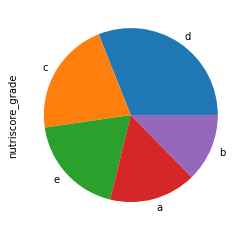

In [ ]:
df_meta['nutriscore_grade'].value_counts().plot.pie()
df_meta['nutriscore_grade'].value_counts(normalize=True)

In [ ]:
df_meta.shape

(155512, 16)